<class 'numpy.ndarray'>
(10000, 8)
[ 1.26000000e+02  6.16877091e-02 -7.73996295e-01 -7.02134033e-01
  4.82019478e-01  5.94862720e-01  7.20000000e+01  7.80000000e+01]
                  0             1             2             3             4  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     173.537100     -0.019274     -0.055412     -0.020011     -0.011571   
std       60.260391      0.996798      0.936588      0.964146      1.002931   
min        0.000000     -1.103657     -1.129803     -1.047126     -1.145616   
25%      129.000000     -0.590254     -0.716672     -0.713789     -0.582796   
50%      177.000000     -0.321731     -0.312765     -0.291873     -0.341801   
75%      220.000000      0.196213      0.338229      0.379464      0.184171   
max      286.000000     23.984711     12.604339      7.820110     14.910312   

                  5             6             7  
count  10000.000000  10000.000000  10000.000000  
mean       0.006253   

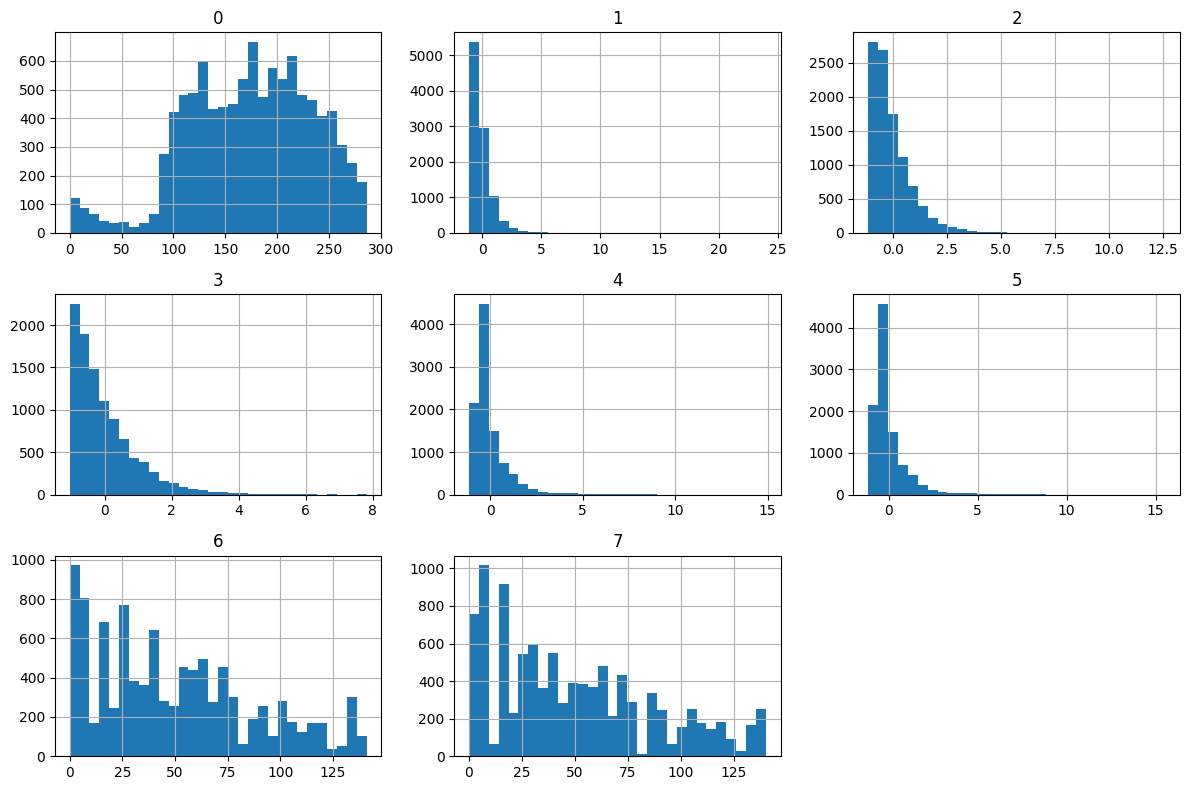

In [ ]:
# inspect the original head file

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load the .npy file
heads = np.load('heads.npy', allow_pickle=True)

# Inspect the content
print(type(heads))
print(heads.shape)
print(heads[3])  # example: print the first element

# If each head is a vector (list/array of numbers)
df = pd.DataFrame(heads)

# Basic statistics
print(df.describe())

# Optional: visualize distributions


df.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

# 0, 6, 7 are categorical values

In [1]:
import pandas as pd
from ast import literal_eval
from tqdm import tqdm

tqdm.pandas()
df = pd.read_csv("dataset\porto.csv")


# convert the POLYLINE from str to list
import multiprocessing as mp
from ast import literal_eval

with mp.Pool(processes=mp.cpu_count()) as pool:
    results = list(tqdm(
        pool.imap(literal_eval, df['POLYLINE']),
        total=len(df),
        desc="Parsing POLYLINE"
    ))

Parsing POLYLINE: 100%|██████████| 1710670/1710670 [03:11<00:00, 8934.32it/s] 


In [2]:
df_pp = pd.DataFrame({'POLYLINE': results})

# drop length of POLYLINE < 2
len_before = len(df_pp)

# df_pp.drop(df[df['POLYLINE'].apply(len) < 2].index, inplace=True)
df_pp.drop(df_pp[df_pp['POLYLINE'].apply(len) < 2].index, inplace=True)

len_after  = len(df_pp)

print(f"there are {len_before - len_after} instances has the number of locations points less than 2")

there are 36510 instances has the number of locations points less than 2


In [ ]:
# preprocessing functions

import numpy as np
from scipy.interpolate import interp1d

def linear_interpo(polyline):
    traj = np.array(polyline)
    l = len(traj)
    if l == 0:
        # Handle empty trajectory
        interp_traj = np.zeros((200, 2))
    elif l == 1:
        # Handle single-point trajectory by repeating
        interp_traj = np.repeat(traj, 200, axis=0)
    else:
        # Original time steps and desired 200 steps
        orig_t = np.linspace(0, 1, l)
        target_t = np.linspace(0, 1, 200)



        # Interpolate x and y separately
        f_x = interp1d(orig_t, traj[:, 0], kind='linear')
        f_y = interp1d(orig_t, traj[:, 1], kind='linear')

        interp_traj = np.stack([f_x(target_t), f_y(target_t)], axis=1)  # shape (200, 2)

    return interp_traj  # shape (200, 2)

def unix_to_5min_interval(timestamps):
    """
    Converts Unix timestamps to 5-minute interval indices (0–287) within a day.

    Parameters:
        timestamps (array-like or pd.Series): Unix timestamps (in seconds)

    Returns:
        pd.Series: 5-minute interval indices ranging from 0 to 287
    """
    # Convert to datetime in Porto timezone (Europe/Lisbon)
    datetime = pd.to_datetime(timestamps, unit='s', utc=True).dt.tz_convert('Europe/Lisbon')

    # Compute minutes since midnight
    minutes = datetime.dt.hour * 60 + datetime.dt.minute

    # Compute 5-minute interval index
    interval = minutes // 5

    return interval


def compute_trip_distance(polyline):
    """
    Computes the Euclidean distance between start and end points of each trajectory.

    Parameters:
        polyline_series (pd.Series): Each entry is a list of (x, y) points.

    Returns:
        np.ndarray: 1D array of distances
    """

    traj = np.array(polyline)

    start = traj[0]
    end = traj[-1]
    dist = np.linalg.norm(end - start)  # ||end - start||

    return dist

def compute_trip_time(polyline):
    """
    Computes trip duration in seconds based on number of points in a trajectory.

    Parameters:
        polyline_series (pd.Series): Each entry is a list of (x, y) points.

    Returns:
        np.ndarray: 1D array of trip times in seconds
    """

    n_points = len(polyline)
    trip_time = max(0, (n_points - 1) * 15)  # at least 0
    
    return trip_time

def coord_to_grid_id(lon, lat, longrids, latgrids):
    # Convert lon and lat to grid indices (0-15)
    x = np.digitize(lon, longrids) - 1
    y = np.digitize(lat, latgrids) - 1
    if 0 <= x < 16 and 0 <= y < 16:
        return y * 16 + x
    else:
        return -1  # mark invalid if out of bounds


In [ ]:
# manually calculated features
#  [batch_size, 8]   8: departure_time, trip_distance,  trip_time, trip_length, avg_dis, avg_speed, start_id, end_id

# x departure_time = convert unix time to categorical values  (a day has been categorise into 288 intervals, every 5 minutes as a interval)
# x trip_distance = ||start coordinate - end coordinate||
# x trip_time: (number of points-1) x 15 seconds
# x trip_length = number of points
# x avg_dis = trip_distance / trip_length
# x avg_speed = trip_distance / trip_time
# x start_id: id of start grid 
# x end_id: id of end grid 


df_pp['trip_distance'] = df_pp['POLYLINE'].progress_apply(compute_trip_distance)

df_pp['departure_time'] = unix_to_5min_interval(df['TIMESTAMP'])

df_pp['trip_time'] = df_pp['POLYLINE'].progress_apply(compute_trip_time)

df_pp['trip_length'] = df_pp['POLYLINE'].progress_apply(len)

df_pp['avg_dis'] = df_pp['trip_distance'] / df_pp['trip_length']

df_pp['avg_speed'] = df_pp['trip_distance'] / df_pp['trip_length']


100%|██████████| 1674160/1674160 [00:00<00:00, 2710134.18it/s]


In [ ]:
#results saved in next cell, do not execute!

# Flatten all [lon, lat] points into one big list
all_coords = [point for traj in df_pp['POLYLINE'] if len(traj) > 0 for point in traj]

# Convert to NumPy array
coords_array = np.array(all_coords)  # shape: (N, 2)

# Initialize empty lists
latitudes = []
longitudes = []

# Extract latitudes and longitudes from each point
for traj in df_pp['POLYLINE']:
    for lon, lat in traj:  # Each point is [lon, lat]
        longitudes.append(lon)
        latitudes.append(lat)

# Compute min and max
min_lat, max_lat = min(latitudes), max(latitudes)
min_lon, max_lon = min(longitudes), max(longitudes)

In [ ]:
# generate start id, end id

from utils.utils import divide_grids

min_lat, max_lat = (36.886104, 51.037119)
min_lon, max_lon = (-15.630759, -3.930948)

boundary = {
    'lati_min': min_lat,
    'lati_max': max_lat,
    'long_min': min_lon,
    'long_max': max_lon
}

latgrids, longrids = divide_grids(boundary,16)

latgrids, longrids = np.array(latgrids), np.array(longrids)


start_ids = []
end_ids = []

# Wrap df_pp['POLYLINE'] with tqdm for progress display
for polyline in tqdm(df_pp['POLYLINE'], desc="Categorizing start/end grid IDs"):
    if len(polyline) >= 2:
        start_lon, start_lat = polyline[0]
        end_lon, end_lat = polyline[-1]
        start_ids.append(coord_to_grid_id(start_lon, start_lat, longrids, latgrids))
        end_ids.append(coord_to_grid_id(end_lon, end_lat, longrids, latgrids))
    else:
        start_ids.append(-1)  # or np.nan
        end_ids.append(-1)

# Add to DataFrame
df_pp['start_id'] = start_ids
df_pp['end_id'] = end_ids

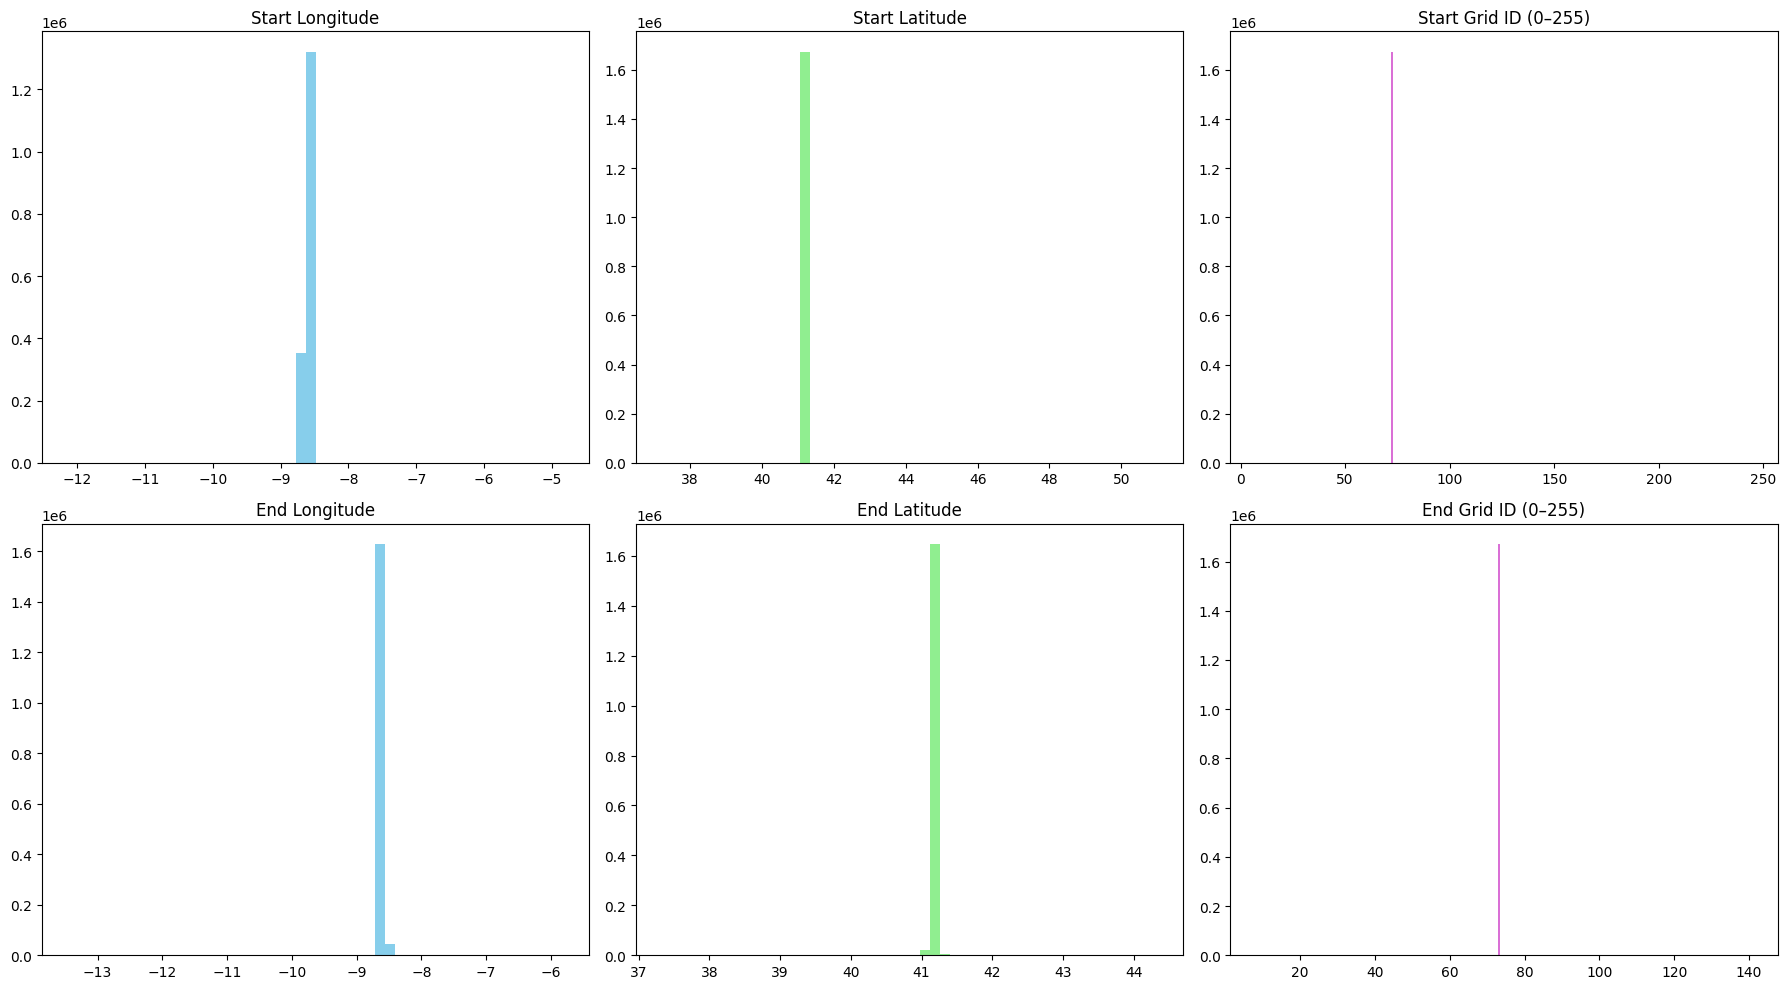

In [ ]:
# plot the histogram about the starting and ending coordinates, do not execute!

import matplotlib.pyplot as plt
# Extract start and end points from POLYLINE
start_lons = []
start_lats = []
end_lons = []
end_lats = []

for polyline in df_pp['POLYLINE']:
    if len(polyline) >= 2:
        start_lon, start_lat = polyline[0]
        end_lon, end_lat = polyline[-1]
        start_lons.append(start_lon)
        start_lats.append(start_lat)
        end_lons.append(end_lon)
        end_lats.append(end_lat)

# Create a new DataFrame for plotting
df_coords = pd.DataFrame({
    'start_lon': start_lons,
    'start_lat': start_lats,
    'end_lon': end_lons,
    'end_lat': end_lats,
    'start_id': df_pp.loc[df_pp['start_id'] != -1, 'start_id'].values,
    'end_id': df_pp.loc[df_pp['end_id'] != -1, 'end_id'].values
})


fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot histograms
axes[0, 0].hist(df_coords['start_lon'], bins=50, color='skyblue')
axes[0, 0].set_title('Start Longitude')

axes[0, 1].hist(df_coords['start_lat'], bins=50, color='lightgreen')
axes[0, 1].set_title('Start Latitude')

axes[0, 2].hist(df_coords['start_id'], bins=256, color='orchid')
axes[0, 2].set_title('Start Grid ID (0–255)')

axes[1, 0].hist(df_coords['end_lon'], bins=50, color='skyblue')
axes[1, 0].set_title('End Longitude')

axes[1, 1].hist(df_coords['end_lat'], bins=50, color='lightgreen')
axes[1, 1].set_title('End Latitude')

axes[1, 2].hist(df_coords['end_id'], bins=256, color='orchid')
axes[1, 2].set_title('End Grid ID (0–255)')

plt.tight_layout()
plt.show()


       trip_distance  departure_time     trip_time   trip_length  \
count   1.674160e+06    1.674160e+06  1.674160e+06  1.674160e+06   
mean    3.602711e-02    1.504789e+02  7.320503e+02  4.980335e+01   
std     4.231963e-02    7.533388e+01  6.838656e+02  4.559104e+01   
min     0.000000e+00    0.000000e+00  1.500000e+01  2.000000e+00   
25%     1.599558e-02    9.700000e+01  4.200000e+02  2.900000e+01   
50%     2.775072e-02    1.530000e+02  6.150000e+02  4.200000e+01   
75%     4.540998e-02    2.110000e+02  8.700000e+02  5.900000e+01   
max     1.041853e+01    2.870000e+02  5.820000e+04  3.881000e+03   

            avg_dis     avg_speed      start_id        end_id  
count  1.674160e+06  1.674160e+06  1.674160e+06  1.674160e+06  
mean   7.770175e-04  7.770175e-04  7.300340e+01  7.303024e+01  
std    1.228499e-03  1.228499e-03  3.511894e-01  7.973074e-01  
min    0.000000e+00  0.000000e+00  7.000000e+00  8.000000e+00  
25%    4.735557e-04  4.735557e-04  7.300000e+01  7.300000e+01  
50%

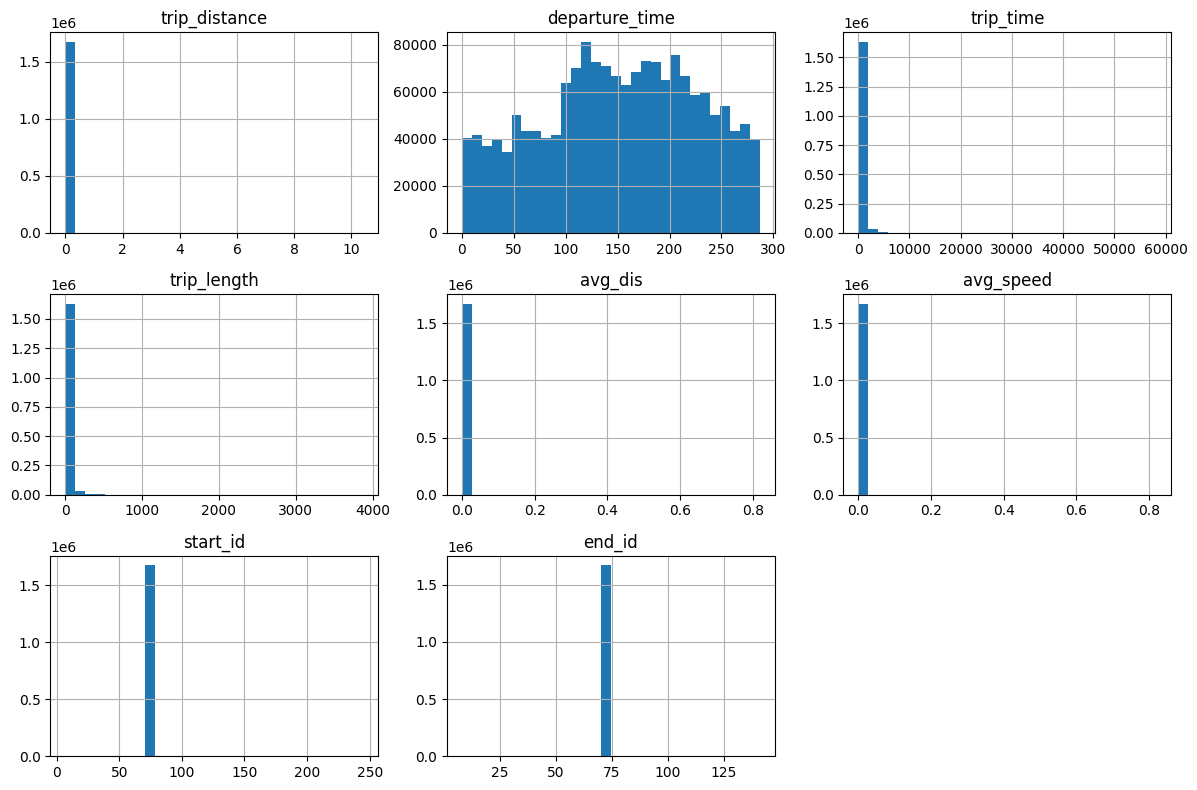

In [ ]:
# describe and plot the df, , do not execute!
import matplotlib.pyplot as plt

print(df_pp.describe())

df_pp.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

In [ ]:
# free memory
del df

In [ ]:
# linear interpolate to length = 200
df_pp['POLYLINE_interpolated'] = df_pp['POLYLINE'].progress_apply(linear_interpo)

100%|██████████| 1674160/1674160 [01:14<00:00, 22481.36it/s]


In [ ]:
# normalisation 
# trip_distance = ||start coordinate - end coordinate||
# trip_time: (number of points-1) x 15 seconds
# trip_length = number of points
# avg_dis = trip_distance / trip_length
# avg_speed = trip_distance / trip_time
 

In [ ]:
# Normalisation
# 'trip_distance', 'trip_time', 'trip_length', 'avg_dis', 'avg_speed'
# Departure Time, Start Grid ID, and End Grid ID do not need to be normalized.

cols_to_normalize = ['trip_distance', 'trip_time', 'trip_length', 'avg_dis', 'avg_speed']

# Apply normalization: (x - mean) / std
df_pp[cols_to_normalize] = df_pp[cols_to_normalize].apply(lambda x: (x - x.mean()) / x.std())

In [ ]:
###########################################################
# The input shape of traj and head list as follows:
# traj: [batch_size, 2, traj_length]   2: latitude and longitude
# head: [batch_size, 8]   8: departure_time, trip_distance,  trip_time, trip_length, avg_dis, avg_speed, start_id, end_id
###########################################################


import numpy as np

np.save('porto_traj.npy', df_pp['POLYLINE_interpolated'].to_numpy())


head_features = ['departure_time', 'trip_distance', 'trip_time', 'trip_length',
                 'avg_dis', 'avg_speed', 'start_id', 'end_id']

np.save('porto_head.npy', df_pp[head_features].to_numpy())
